In Chapter 1 we mentioned that the most common supervised learning tasks are regression (predicting values) and classfication (predicting classes). In Chapter 2 we explored a regression task, predicting housing values, using various algorithms such as Linear Regression, Decision Trees, and Random Forests (which will be explained in further detail in later chapters). Now we will turn our attention to classification systems.

In [16]:
import sys
assert sys.version_info >= (3, 7)
import sklearn
assert sklearn.__version__ >= "1.0.1"
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

from pathlib import Path

IMAGES_PATH = Path() / "images" / "classification"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST
In this chapter we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. THis set has been studied so much that it is often called the "hello world" of Machine Learning: whenever people come up with a new classification algorithm they are curious to see how it will perform on MNIST, and anyone who learned Machine Learning tackles this dataset sooner or later.

Scikit-Learn provides many helper functions to download popular datasets. MNIST is one of them. The following code fetches the MNIST dataset:

In [17]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn generally have a similar dictionary structure, including the following:
- a DESCR key describing the dataset
- A data key containing an array with one row per instance and one column per feature
- A target key containing an array with the labels
Let's look at these arrays

In [18]:
X, y = mnist['data'], mnist['target']
print(f'X:{X.shape}\ny:{y.shape}')

X:(70000, 784)
y:(70000,)


There are 70k images, and each image has 784 features. This is because each image is 28x28 pixels, and each feature simply represents one pixel's intensity, from 0 (white) to 255 (black). Let's take a peek at one digit from the dataset. All you need to do is grab an instance's feature vector, reshape it to a 28x28 array, and display it using Matplotlib's `imshow()` function:

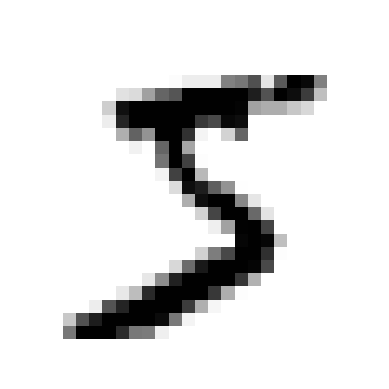

In [19]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]
some_digit_image = some_digit.values.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

This looks like a 5, and indeed that's what the label tells us:

In [20]:
y.iloc[0]

'5'

Note that the label is a string. Most ML algorithms expect numbers, so let's cast y to integer:

In [21]:
import numpy as np
y = y.astype(np.uint8)

To get a feel for the complexity of the classification task, the figure below shows a few more images from the MNIST dataset

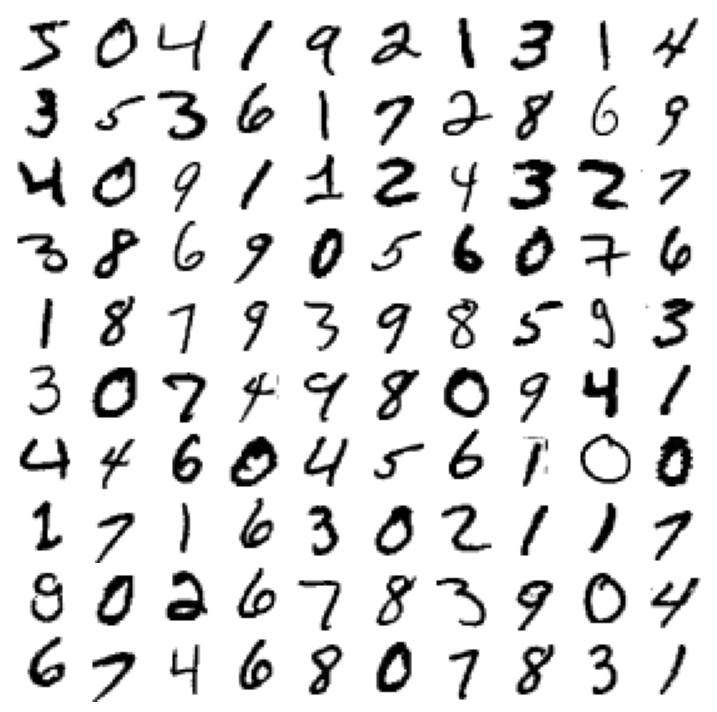

In [44]:
def plot_digit(image_data):
    image = image_data.reshape(28,28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X.iterrows()):
    if idx==100:break
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data[1].values)
plt.subplots_adjust(wspace=0, hspace=0)
save_fig("more_digits_plot", tight_layout=False)
plt.show()

But wait! We should always create a test set and set it aside before inspecting the data closely. The MNIST dataset is actually already split into a training set (the first 60k images) and a test set (the last 10k images):

In [45]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar (you don't want one fold to be missing some digits). Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. Shuffling the dataset ensures that this won't happen.

Note that shuffling can be inappropriate in instances where we're working with time series data.

## Training a Binary Classifier
Let's simplify the problem for now and only try to identify one digit -- for example, the number 5. This "5-detector" will be an example of a *binary classifier*, capable of distinguishing between just two classes, 5 and not-5. Let's create the target vectors for the classification task:

In [46]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Now let's pick a classifier and train it. A good place to start is with a *Stochastic Gradient Descent* (SGD) classifer, using Scikit_learn's `SGDClassifier` class. This classifier has the advantage of being capable of handling very large datasets efficiently. This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well-suited for online learning), as we will see later. Let's create an `SGDClassifier` and train it on the whole training set:

In [48]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use our trained classifier to detect images of the of the number 5.

In [49]:
sgd_clf.predict([some_digit])

c:\Users\nichceme\Documents\python-projects\hands-on-ml\ch3-classification\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

The classifier guesses that this images represents a 5 (True). Looks like it guessed right in this particular case! Now, let's evaluate this model's performance.

## Performance Measures
Evaluating a classifier is often significantly trickier than evaluating a regressor, so we will spend a large part of this chapter on this topic. The are many performance measures available.

## Measuring Accuracy Using Cross-Validation
A good way to evaluate a model is to use cross-validation, just as we did previously.

## Implementing Cross-Validation
Occasionally, we will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. In these cases, we can implement the cross-validation ourselves. The following code does roughly the same thing as Scikit-Learn's `cross_val_score()` function, and it prints the same result:

In [83]:
X_train.iloc[[2,4]]

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
X_test

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
60000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train.iloc[test_index]

    clone_clf.fit(X_train_fold, y_train_fold)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.8642
0.87215
0.88795


The `StratifiedKFold` class performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. Then it counts the number of correct predictions and outputs the ratio of correct predictions.

Let's use the `cross_val_score()` function to evaluate our `SGDClassifier` model, using K-fold cross-validation with three folds. Remember that K-fold cross-validation means splitting the training set into K folds (in this case, three), then making predictions and evaluating them on each fold using a model trained on the remaining folds

In [87]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Wow, above 93% accuracy (ratio of correct predictions) on all cross-validated folds? This looks amazing, doesn't it? Before we get too excited though, we should look at a very dumb classifier that just classifies every single image in as being "not-5".

In [89]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)